In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
import pandas as pd
import os
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [11]:
class FractalDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.labels = pd.read_csv(label_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name).convert('L')  # Convert to grayscale if needed
        d_value = torch.tensor(self.labels.iloc[idx, 1], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, d_value

class FractalCNN(nn.Module):
    def __init__(self):
        super(FractalCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.fc1 = None
        self.fc2 = nn.Linear(256, 1)

    def _initialize_fc(self, x):
        x = self.convs(x)
        flattened_size = x.view(x.size(0), -1).shape[1]
        self.fc1 = nn.Linear(flattened_size, 256).to(x.device)  # Ensure fc1 is on the same device

    def convs(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        return x

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x)
        x = self.convs(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    loss_values = []  # List to store loss values

    model.to(device)  # Move the model to the GPU

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        model.train()  # Set the model to training mode
        for images, labels in train_loader:
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU
            labels = labels.unsqueeze(1)  # Ensure labels match output shape

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)  # Average loss for the epoch
        loss_values.append(avg_loss)  # Store the average loss

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Plot the loss function after training
    plt.figure(figsize=(8,6))
    plt.plot(range(1, num_epochs + 1), loss_values, marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

Epoch [1/10], Loss: 1.9523
Epoch [2/10], Loss: 0.6312
Epoch [3/10], Loss: 0.3400
Epoch [4/10], Loss: 0.1009
Epoch [5/10], Loss: 0.1658
Epoch [6/10], Loss: 0.0480
Epoch [7/10], Loss: 0.0770
Epoch [8/10], Loss: 0.0390
Epoch [9/10], Loss: 0.0425
Epoch [10/10], Loss: 0.0253


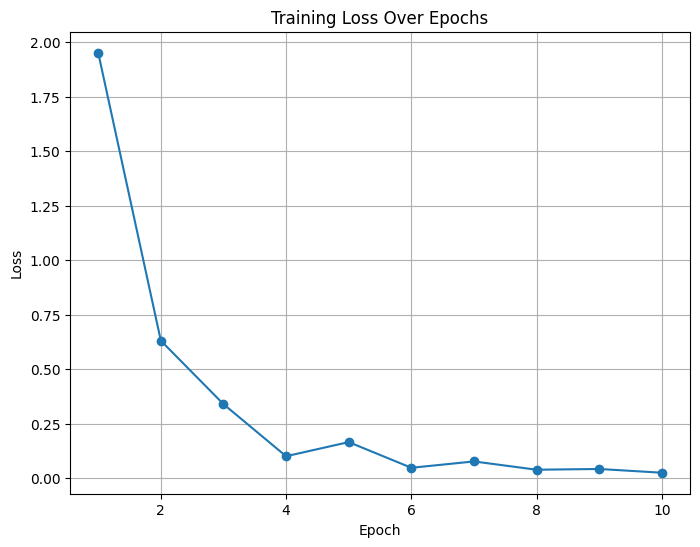

In [12]:
image_dir = r'/home/apd/Projects/FractalFluency/datasets/coastline_edge_test'
labels_dir = r'/home/apd/Projects/FractalFluency/datasets/coastline_edge_test/labels.csv'

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = FractalDataset(image_dir=image_dir, label_file=labels_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

model = FractalCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Average Test Loss: 0.0518
True vs Predicted D values:
True: [1.2], Predicted: [1.1941886]
True: [1.2060606], Predicted: [1.2516232]
True: [1.2121212], Predicted: [1.263605]
True: [1.2181818], Predicted: [1.3313851]
True: [1.2242424], Predicted: [1.4090728]
True: [1.230303], Predicted: [1.3407292]
True: [1.2363636], Predicted: [1.1783843]
True: [1.2424242], Predicted: [1.2378709]
True: [1.2484848], Predicted: [1.3026135]
True: [1.2545455], Predicted: [1.0727654]
True: [1.260606], Predicted: [1.1759105]
True: [1.2666667], Predicted: [1.1911601]
True: [1.2727273], Predicted: [1.3123683]
True: [1.2787879], Predicted: [1.1859128]
True: [1.2848485], Predicted: [1.3089231]
True: [1.290909], Predicted: [1.1813741]
True: [1.2969697], Predicted: [1.3311284]
True: [1.3030303], Predicted: [1.2186149]
True: [1.3090909], Predicted: [1.327917]
True: [1.3151516], Predicted: [1.3686819]
True: [1.3212122], Predicted: [1.3173428]
True: [1.3272728], Predicted: [1.1634921]
True: [1.3333334], Predicted: [1.

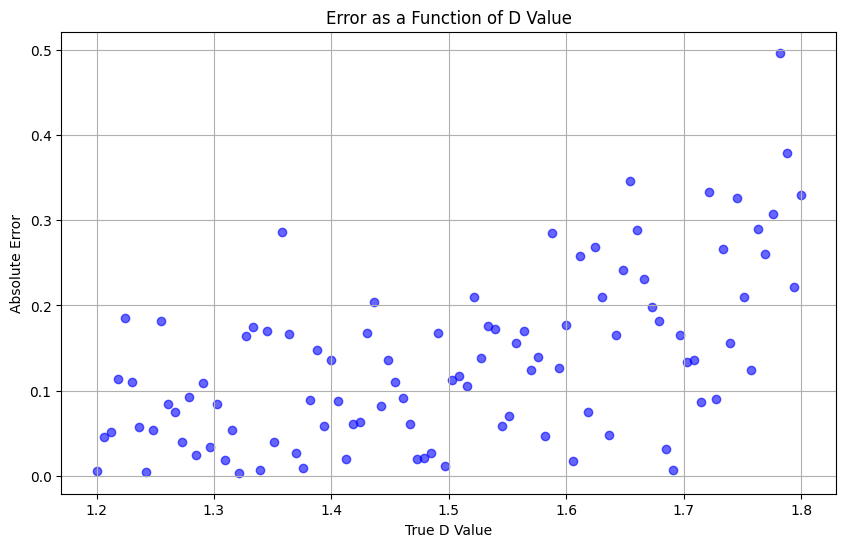

In [19]:
# Paths to your test dataset and labels
test_image_dir = r'/home/apd/Projects/FractalFluency/datasets/coastline_edge_test'
test_labels_dir = r'/home/apd/Projects/FractalFluency/datasets/coastline_edge_test/labels.csv'

# Use the same transform as used for training
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Prepare the test dataset and DataLoader
test_dataset = FractalDataset(image_dir=test_image_dir, label_file=test_labels_dir, transform=test_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,         # Adjust based on your CPU cores
    pin_memory=True        # Speeds up data transfer to GPU
)

# Set the model to evaluation mode
model.eval()

# Initialize variables to store test results
test_loss = 0.0
criterion = nn.MSELoss()
predictions = []
true_values = []

# Disable gradient computation for testing
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the same device as the model
        images = images.to(device)
        labels = labels.to(device)
        
        # Reshape labels to match the output shape
        labels = labels.view(-1, 1)
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Store predictions and true values for further analysis
        predictions.extend(outputs.cpu().numpy())
        true_values.extend(labels.cpu().numpy())

# Compute the average test loss
test_loss /= len(test_loader)
print(f'Average Test Loss: {test_loss:.4f}')

# Calculate the Mean Absolute Error (MAE)
predictions = np.array(predictions)
true_values = np.array(true_values)
mae = np.mean(np.abs(predictions - true_values))

# Print or plot the comparison
print("True vs Predicted D values:")
for true, pred in zip(true_values, predictions):
    print(f"True: {true}, Predicted: {pred}")
    
print(f'Average Deviation (MAE): {mae:.4f}')

# Calculate the error for each prediction
errors = np.abs(predictions - true_values)

# Plot error as a function of D value
plt.figure(figsize=(10, 6))
plt.scatter(true_values, errors, color='blue', alpha=0.6)
plt.title('Error as a Function of D Value')
plt.xlabel('True D Value')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()


In [18]:
## Save model

torch.save(model.state_dict(), r'/home/apd/Projects/FractalFluency/trained_models')


model = FractalCNN()
model.load_state_dict(torch.load('fractal_cnn.pth'))
model.to(device)


RuntimeError: File /home/apd/Projects/FractalFluency/trained_models cannot be opened.